# 산악지역 이동통신 API
##### 산악지역(국립공원, 도립공원, 군립공원) 또는 자신의 위치정보를 통해 해당지역에 위치한 이동통신서비스를 목적으로 개설된 무선국 정보를 제공 받을 수 있습니다.
### 데이터 받는 방법
##### 1. openAPI - X (전체 데이터를 받기 어렵다)
##### https://spectrummap.kr/cop/bbs/selectBoardArticle.do?menuNo=300588&bbsId=BBSMSTR_000000000172&nttId=14341&menuNo=300510&gubun=1
##### 2. 웹에서 직접 받은 후 가공 - O (전체 데이터 받기위해 이 방법이 훨씬 좋다)
##### https://spectrummap.kr/gis/nationalpark_service.do?menuNo=3005101¶00511¶

In [32]:
# 패키지 임포트
import requests
import pandas as pd
import json
import re
import os

import warnings
warnings.filterwarnings('ignore')

In [26]:
# 경위도 좌표치환 메서드
def dms_to_decimal(degrees, minutes, seconds):
    return degrees + (minutes / 60) + (seconds / 3600)

# 문자열에서 도, 분, 초를 추출하는 함수
def parse_dms(dms_str):
    # 정규식을 이용해 DMS 문자열에서 도, 분, 초를 추출
    match = re.match(r"(\d+)° (\d+)' (\d+\.?\d*)\"", dms_str)
    if match:
        degrees = int(match.group(1))
        minutes = int(match.group(2))
        seconds = float(match.group(3))
        return dms_to_decimal(degrees, minutes, seconds)
    else:
        return None

### 1. openAPI 예시코드 (전체 데이터를 받을 수 없습니다. 웹에서 원본 데이터 받으세요)

In [ ]:
# 산악지역 이동통신 API
url = 'https://spectrummap.kr/openapiNew.do?'

# 요청 헤더에 User-Agent 추가
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

key = ''
params = {
    'key': key,  # 인증키 / 필수값
    'searchId': '07', # 호출서비스구분 / 필수값
    'type':'json', # 데이터타입
    'pIndex': '1', # 페이지위치 
    'pSize': '1000', # 페이지당요청숫자
    'SCH_CD' : 'MOBILE', # 검색구분 : MOBILE(기지국정보) / 필수값
    'PARK_CD' : '1', # 공원구분 : 1(국립공원), 2(도립공원), 3(군립공원) / 필수값
    'QUERY': '북한산', # 공원명 : 공원명 or ALL / 필수값
    'CUS_CD' : 'ALL', # 시설자 구분 : SK, KT, LG, ALL
    'SERVICE_CD' : 'ALL', # 서비스 구분 : 2G, 3G, 4G, 5G, ALL
    #'RSCP_PW' : 'ALL' # 
}

response = requests.get(url, params=params, headers=headers)
json_str = response.content.decode('utf-8')
json_object = json.loads(json_str)

In [ ]:
df = pd.DataFrame(json_object['RESULT'])

# 컬럼명 변경 매핑
column_mapping = {
    'SERVICE_NAME': '용도',
    'RNUM': '번호',
    'EQM_CNT': '장치수',
    'RDS_PMS_NO': '허가번호',
    'ARW_GAN_NMV': '출력(W)',
    'GND_ALTD_HET': '지상고',
    'EXPS_ALTD_HET': '노출고',
    'LON': '경도',
    'ALT_ALTD_HET': '해발고',
    'RDS_TRS_ADR': '주소(설치장소)',
    'LAT': '위도',
    'ARW_FORM_CD': '안테나설치형태'
}

# 컬럼명 변경
df = df.rename(columns=column_mapping)

# 컬럼 순서 변경 (숫자에 맞게 정렬)
desired_order = [
    '허가번호',         # 1
    '주소(설치장소)',   # 2
    '용도',             # 3
    '장치수',           # 4
    '경도',             # 5
    '위도',             # 6
    '출력(W)',          # 7
    '안테나설치형태',    # 8
    '노출고',           # 9
    '지상고',           # 10
    '해발고'            # 11
]

# 컬럼 순서 변경
df = df[desired_order]

# 불필요한 문자 제거
df['안테나설치형태'] = df['안테나설치형태'].apply(lambda x: str(x).strip('\r\n\t ') if isinstance(x, str) else x)

# ======================================

### 2. 웹에서 직접 받은 후 가공 - O
##### 1) 웹에서 공원별 산악지역 이동통신 무선국 데이터를 받습니다
##### 2) 파일을 병합합니다
##### 3) 데이터를 가공합니다 (전처리, preprocessing)

In [8]:
import os
import pandas as pd

In [12]:
# 산악지역 이동통신 무선국 데이터가들어있는 폴더
folder_path = '원본데이터'

# 엑셀 파일만 필터링
excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xls') or f.endswith('.xlsx')]

In [14]:
# 모든 엑셀 파일을 읽어서 하나의 데이터프레임으로 합치기
df_list = []  # 여러 데이터프레임을 저장할 리스트

# 각 엑셀 파일을 판다스로 읽어들여 리스트에 추가
for file in excel_files:
    file_path = os.path.join(folder_path, file)  # 파일 경로 완성
    df = pd.read_excel(file_path)  # 엑셀 파일을 읽어서 DataFrame으로 변환
    df_list.append(df)  # 읽은 DataFrame을 리스트에 추가

# 모든 데이터프레임을 하나로 합치기 (기본적으로 행 단위로 합침)
final_df = pd.concat(df_list, ignore_index=True)

In [16]:
final_df['허가연도'] = final_df['허가번호'].astype(str).apply(lambda x: x[2:6])

In [34]:
# 위경도좌표 십진수변환
final_df['위도'] = final_df['위도'].apply(parse_dms)
final_df['경도'] = final_df['경도'].apply(parse_dms)

In [20]:
# 컬럼 순서 변경 (배치 순서대로 변경)
new_column_order = [
    '구분',        
    '이름',
    '허가번호',
    '허가연도',
    '시설자명',
    '설치장소',
    '용도',
    '장치개수',
    '주파수(MHz)',
    '출력(W)',
    '안테나설치형태',
    '대표이득',
    '해발고',
    '지상고',
    '노출고',
    '위도',
    '경도'
]

# 데이터프레임을 새로운 컬럼 순서로 재정렬
final_df = final_df[new_column_order]

In [22]:
final_df.sort_values(by = ['구분', '이름', '허가번호'], ascending=True, inplace=True)

In [36]:
final_df.to_excel('산악지역이동통신무선국.xlsx', index=None)

In [38]:
final_df.isnull().sum()

구분             0
이름             0
허가번호           0
허가연도           0
시설자명          44
설치장소           0
용도             0
장치개수           0
주파수(MHz)    2325
출력(W)       2325
안테나설치형태     1080
대표이득          57
해발고           87
지상고          791
노출고         1685
위도             0
경도             0
dtype: int64

In [42]:
# '허가번호' 컬럼 중복값 개수 확인 >> 중복값 없음
print('허가번호 중복값 제거 전 행 개수 : ', len(f))
print('허가번호 중복값 제거 후 행 개수 : ', len(f.drop_duplicates(subset='허가번호')))

허가번호 중복값 제거 전 행 개수 :  14406
허가번호 중복값 제거 후 행 개수 :  14406


### 집계

In [84]:
# 집계를 위한 컬럼 추가
df['cnt'] = 1

In [104]:
pie = df.groupby(by = '시설자명', as_index=False)['cnt'].sum()\
.rename(columns={'cnt':'합계'}).sort_values(by = '합계', ascending = False).reset_index(drop=True)

In [106]:
# 패키지 임포트
import plotly.express as px
import plotly.graph_objects as go

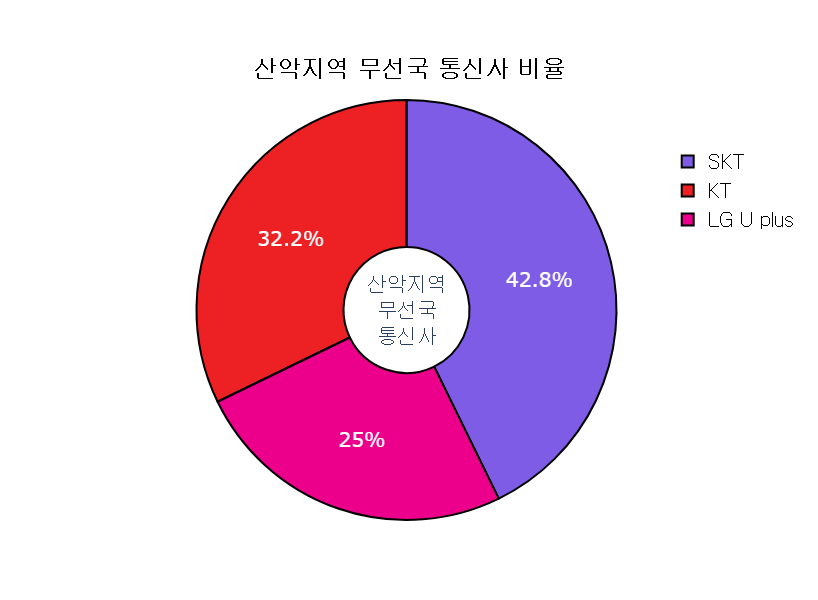

In [316]:


fig = go.Figure(data=[go.Pie(
    labels=pie['시설자명'],
    values=pie['합계'],
    hole=.3,  # 원형 차트 만들기
    marker=dict(
        colors=[  # 색상을 '시설자명' 기준으로 지정
            '#7F5CE6',  # SKT (연한 파란색)
            '#ED2024',   # KT (빨간색)
            '#EC008B'    # LG U plus (핑크색)
        ]
    )
)])

# 도화지 크기 조정
fig.update_layout(
    title='산악지역 무선국 통신사 비율',
    width=800,  # 차트의 가로 크기
    height=600,  # 차트의 세로 크기
    title_x=0.5,  # 제목 위치 조정 (0은 왼쪽, 1은 오른쪽, 0.5는 가운데)
    title_y=0.9,  # 제목 위치 조정 (0은 왼쪽, 1은 오른쪽, 0.5는 가운데)
    title_font=dict(size=24, family='Gulim', color='black'),  # 제목 텍스트 스타일 설정

    annotations=[dict(
        text='산악지역<br>무선국<br>통신사',  # 표시할 텍스트
        x=0.5,  # X 위치 (0은 왼쪽, 1은 오른쪽)
        y=0.5,  # Y 위치 (0은 아래, 1은 위)
        font_size=20,  # 글자 크기
        font_family = 'Gulim',
        showarrow=False,  # 화살표 없음
        xanchor="center",  # X 기준: 텍스트의 중앙
        yanchor="middle"  # Y 기준: 텍스트의 중앙
    )],

    # 범례 스타일 설정
    legend=dict(
        #title="통신사",  # 범례 제목
        #title_font=dict(size=16, family='Arial', color='black'),  # 범례 제목 폰트 설정
        font=dict(size=20, family='Gulim', color='black'),  # 범례 항목 폰트 설정
        x=0.9,  # 범례 위치 (0은 왼쪽, 1은 오른쪽, 0.5는 가운데)
        y=0.9,  # 범례 위치 (0은 아래, 1은 위, 0.5는 가운데)
        traceorder='normal',  # 범례 항목의 순서
        orientation='v'  # 범례 항목의 배치: 수직('v') 또는 수평('h')
    )
)

fig.update_traces(hoverinfo='label+value', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.show()


### 이건 쫌 쓰기 그렇구만

In [146]:
# 시각화 패키지
import matplotlib 
import matplotlib.pyplot as plt

# 한글 설정 약식 코드 - 여기선 굴림으로 지정했습니다
plt.rcParams['font.family']='gulim'
plt.rcParams['axes.unicode_minus'] = False

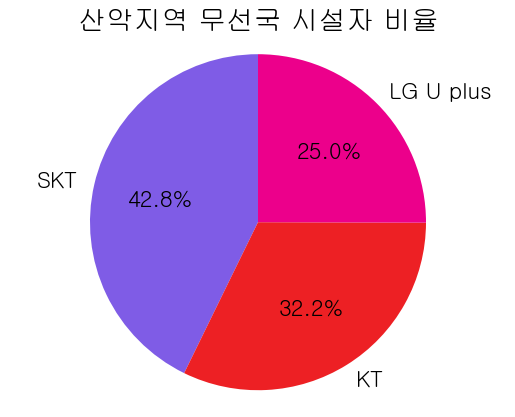

In [174]:
colors = ['#7F5CE6', '#ED2024', '#EC008B']

# 폰트 크기와 스타일을 설정하는 방법
font_properties = {'fontsize': 16}

# 파이 차트 그리기
fig, ax = plt.subplots()
ax.pie(pie['합계'], labels=pie['시설자명'], colors=colors, autopct='%1.1f%%', 
       startangle=90, textprops=font_properties)
ax.set_title('산악지역 무선국 시설자 비율', size = 20)
ax.axis('equal')  # 원형 유지

# 차트 출력
plt.show()

# 결측치, 중복값 확인

In [44]:
# 결측치 확인
final_df.isnull().sum()

구분             0
이름             0
허가번호           0
허가연도           0
시설자명          44
설치장소           0
용도             0
장치개수           0
주파수(MHz)    2325
출력(W)       2325
안테나설치형태     1080
대표이득          57
해발고           87
지상고          791
노출고         1685
위도             0
경도             0
dtype: int64

In [52]:
# 중복값 확인 >> 없음
print("중복값 제거 전 : ", len(final_df))
print("중복값 제거 후 : ", len(final_df.drop_duplicates(subset='허가번호', keep='first')))

중복값 제거 전 :  14406
중복값 제거 후 :  14406


# 주파수 KDE plot (커널 밀도 차트)

In [332]:
# 필요한 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 고해상도 디스플레이 설정
%config InlineBackend.figure_format = 'retina'
# 폰트를 'Malgun Gothic'으로 설정
plt.rcParams['font.family'] = "Malgun Gothic"
# 마이너스 부호 깨짐 현상 해결
plt.rcParams["axes.unicode_minus"] = False

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# Seaborn 시각화 패키지 임포트
import seaborn as sns
sns.set(font="Malgun Gothic",             # 폰트 설정
        rc={"axes.unicode_minus":False})  # 마이너스 부호 깨짐 현상 방지
sns.set_theme(style="white",                       # 테마 
              rc={"axes.facecolor": (0, 0, 0, 0)}) # 배경 색 (투명하게)

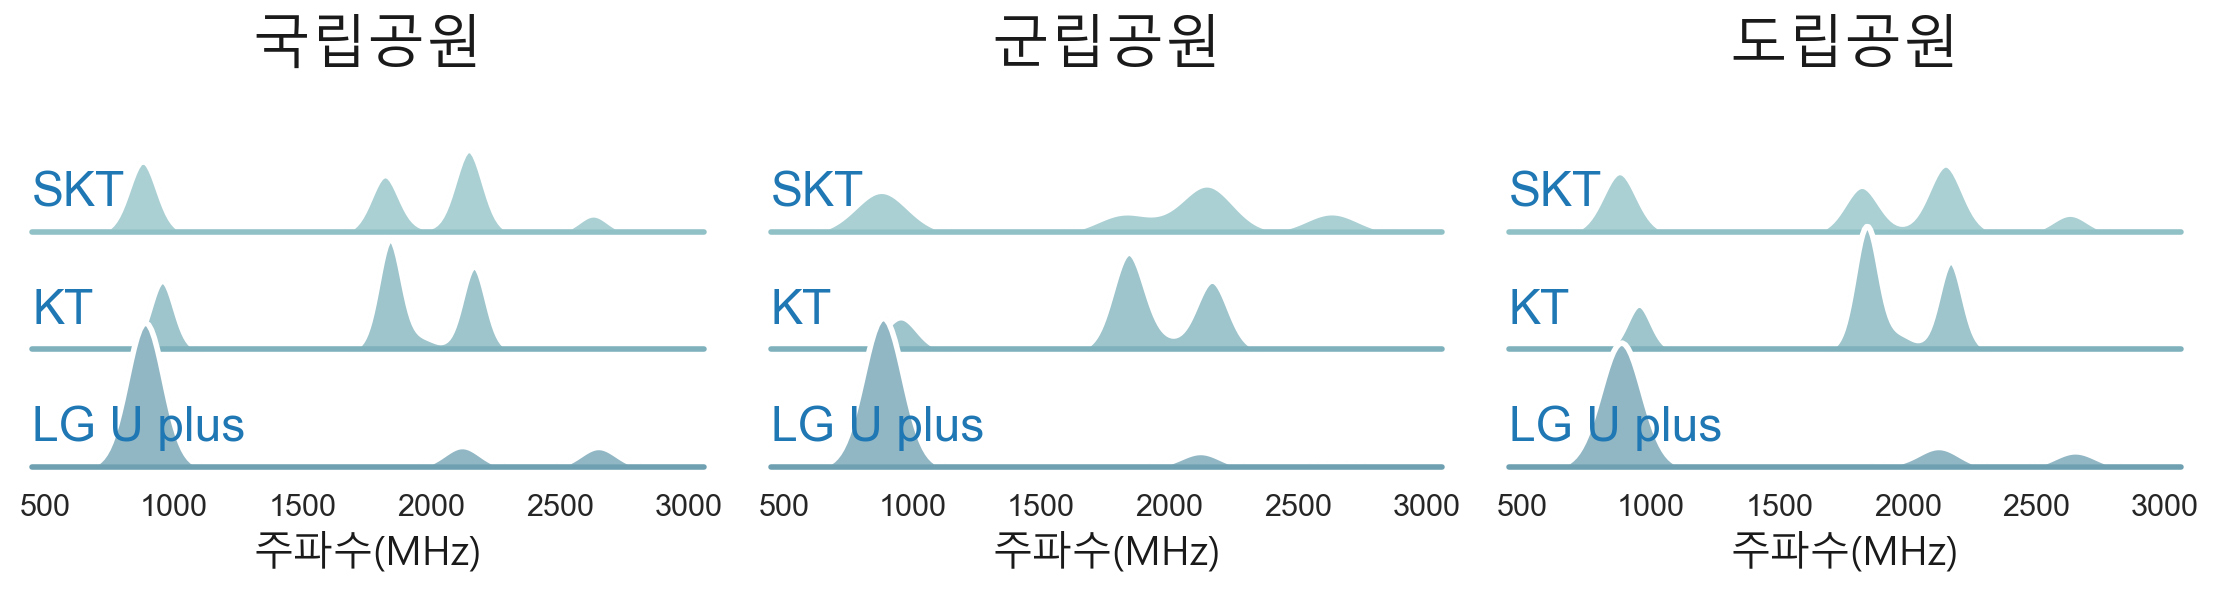

In [352]:
# 색 설정
pal = sns.cubehelix_palette(n_colors=10, # 색상의 수
                            rot=-.25,    # 색상 회전 값
                            light=.7)    # 색상 밝기

# Create FacetGrid object
# 데이터를 다른 묶음(행, 열 기준) 으로 나눈다.
g = sns.FacetGrid(data=df, 
                  row='시설자명', # 행 (범주형)
                  col='구분',    # 열 (범주형)
                  hue='시설자명', # 해당 값으로 색 구분
                  aspect=4,     # 각 그림의 가로 세로 비율 (가로 = 세로 * 4)
                  height=1,     # 각 그림의 세로 크기
                  sharey=True,  # X축 공유
                  sharex=True,  # Y축 공유
                  palette=pal)  # 색 설정

# kde (커널 밀도 차트)
g.map(sns.kdeplot, 
      '주파수(MHz)',         # X축에 사용할 변수
      clip_on=False, # 그래프 영역을 벗어나는 부분(마이너스 등) 잘라내기
      bw_adjust=.5,  # 대역폭 조정
      fill=True,     # 색 채우기
      alpha=1,       # 채우기 색 투명도 0 (투명) - 1 (불투명)
      linewidth=1.5) # 선 굵기

# kde - line
g.map(sns.kdeplot, 
      '주파수(MHz)',
      clip_on=False,
      bw_adjust=.5,
      fill=True,
      linewidth=2,
      color="w")

# refline : reference line (기준선)
g.refline(y=0, 
          linewidth=2,
          linestyle="-",
          color=None,
          clip_on=False)

# 각 차트의 제목에 무엇이 나올지 설정
g.set_titles(template='{col_name}', 
             row_template="", 
             col_template="")

# axes 직접 접근, 1차원 행렬로 표현
axs = g.axes.ravel()
# 각 차트에 직접 접근해서 title과 text를 직접 설정한다.
for i, ax in enumerate(axs):
    
    # 열 title 수정 - 제일 윗 부분만 title이 존재하도록 한다
    if i == 0 or i== 1 or i == 2:
        axs[i].set_title(ax.get_title(),
                         fontdict={"fontsize":"xx-large", "color":"k", "family":"Malgun Gothic"},
                         pad=0) # 간격 
    else :
        axs[i].set_title('')
    
    # 아래 X축 라벨 설정
    if i == 6 or i == 7 or i == 8:
        axs[i].set_xlabel(xlabel = '주파수(MHz)', 
                          fontdict={"fontsize":"large",
                                    "color":"k",
        # 한글 설정을 위해서는 각 그림(축공간, axs[i])에 폰트 설정을 각각 해줘야 한다.
                                    "family":"Malgun Gothic"}) 
        
    
    # 각 차트의 왼쪽에 pclass를 보여준다.
    text = ax.annotate(list(g.axes_dict.keys())[i][0], 
                       xy=(0, 0.25), xycoords="axes fraction", rotation=0, 
                       ha="left", va="center",
                       fontsize="x-large", color='tab:blue')

# Y축 눈금, 라벨 없애기
g.set(yticks=[], ylabel="")
# 축 없애기
g.despine(bottom=True, left=True)
# 차트 위아래가 겹쳐보이기 위한 간격 조정
g.figure.subplots_adjust(hspace=-.25)

plt.savefig('구분및통신사별주파수분포.png', dpi = 400)
plt.show()
